In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import pandas as pd
import os
from fastprogress.fastprogress import master_bar, progress_bar # El del Titanic

from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, RepeatChannel, NormalizeIntensity

# Potser no cal
import numpy as np

In [5]:
device = torch.device("cuda:0")

In [6]:
working_directory = '/mnt/datasets/fastcovnet/'

In [7]:
# Cohort read
data = pd.read_csv(os.path.join(working_directory,'full_covid_dataset.csv'),"|")

In [8]:
BodyPartExamined = ["CHEST"]
data = data[data.BodyPartExamined.isin(BodyPartExamined)]

image_file_list = data.path_jpg.tolist()

num_total = len(image_file_list) 

In [9]:
print("Total count =",len(image_file_list))

Total count = 234706


In [10]:
imagenet_mean = np.array((np.full((224,224), 0.485), np.full((224,224), 0.456), np.full((224,224), 0.406)))
imagenet_std = np.array((np.full((224,224), 0.229), np.full((224,224), 0.224), np.full((224,224), 0.225)))

train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    RepeatChannel(3),
    ScaleIntensity(),
    NormalizeIntensity(subtrahend=imagenet_mean, divisor=imagenet_std),
    RandRotate(range_x=90, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    RepeatChannel(repeats=3),
    ScaleIntensity(),
    NormalizeIntensity(subtrahend=imagenet_mean, divisor=imagenet_std),
    ToTensor()
])

In [11]:
class COVID_Dataset(Dataset):

    def __init__(self, image_files, transforms):
        self.image_files = image_files
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index])

train_ds = COVID_Dataset(image_file_list, val_transforms)
train_loader = DataLoader(train_ds, batch_size=500, shuffle=False, num_workers=10)

In [12]:
net = resnet50(pretrained=True).to(device)

In [13]:
# We remove the classifier and the relu, since we want to extract the features
net.fc = nn.Sequential()
net.layer4[2].relu = nn.Sequential()

In [44]:
features = []
n_batches = len(train_loader)

with torch.no_grad():
    for i, batch in progress_bar(enumerate(train_loader), total=len(train_loader)):

        # move batch to device
        batch = batch.to(device)

        # forward pass through the network to get the features
        batch_features = net(batch)

        # features to numpy => squeeze removes all dim=1
        batch_features = torch.squeeze(batch_features).cpu().numpy()

        # collect features
        features.append(batch_features)
        print(f'\rProcessed {i+1} of {n_batches} batches', end='', flush=True)

# stack the features into a N x D matrix
features = np.vstack(features)

print(f'\nFeatures are {features.shape}')

Processed 470 of 470 batches
Features are (234706, 2048)


In [45]:
pd.DataFrame(features).to_csv('features_retrieval.csv', index=False, sep='|')

#### From this point, we change kernel and stop using MONAI, since it has a bug where PCA freezes

In [1]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
# t-SNE: https://distill.pub/2016/misread-tsne/
# PCA, t-SNE i k-Means: https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6
# Retrieval class from Kevin McGuinness

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from fastprogress.fastprogress import master_bar, progress_bar # El del Titanic

import pandas as pd

import numpy as np
import os
from PIL import Image

import time

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [2]:
working_directory = '/mnt/datasets/fastcovnet/'

features = pd.read_csv('features_retrieval.csv',"|").to_numpy()
data = pd.read_csv(os.path.join(working_directory,'full_covid_dataset.csv'),"|")
BodyPartExamined = ["CHEST"]
data = data[data.BodyPartExamined.isin(BodyPartExamined)].reset_index(drop=True)

In [3]:
features_norm = normalize(features, norm='l2')

In [4]:
pca = PCA(512, whiten=True)
features_pca = pca.fit_transform(features_norm)
features_pca = normalize(features_pca, norm='l2')

### Discarding by std

In [9]:
avg = []
std = []

for i,k in progress_bar(enumerate(range(len(data))), total=len(data) ):
    im = Image.open(data.path_jpg[k])
    arr = np.array(im)
    std.append(arr.std())
    avg.append(arr.mean())

In [10]:
np_std = np.array(std)
# np_avg = np.array(avg)   # Discarding images by its low average values doesn't help too much, it's much better by std

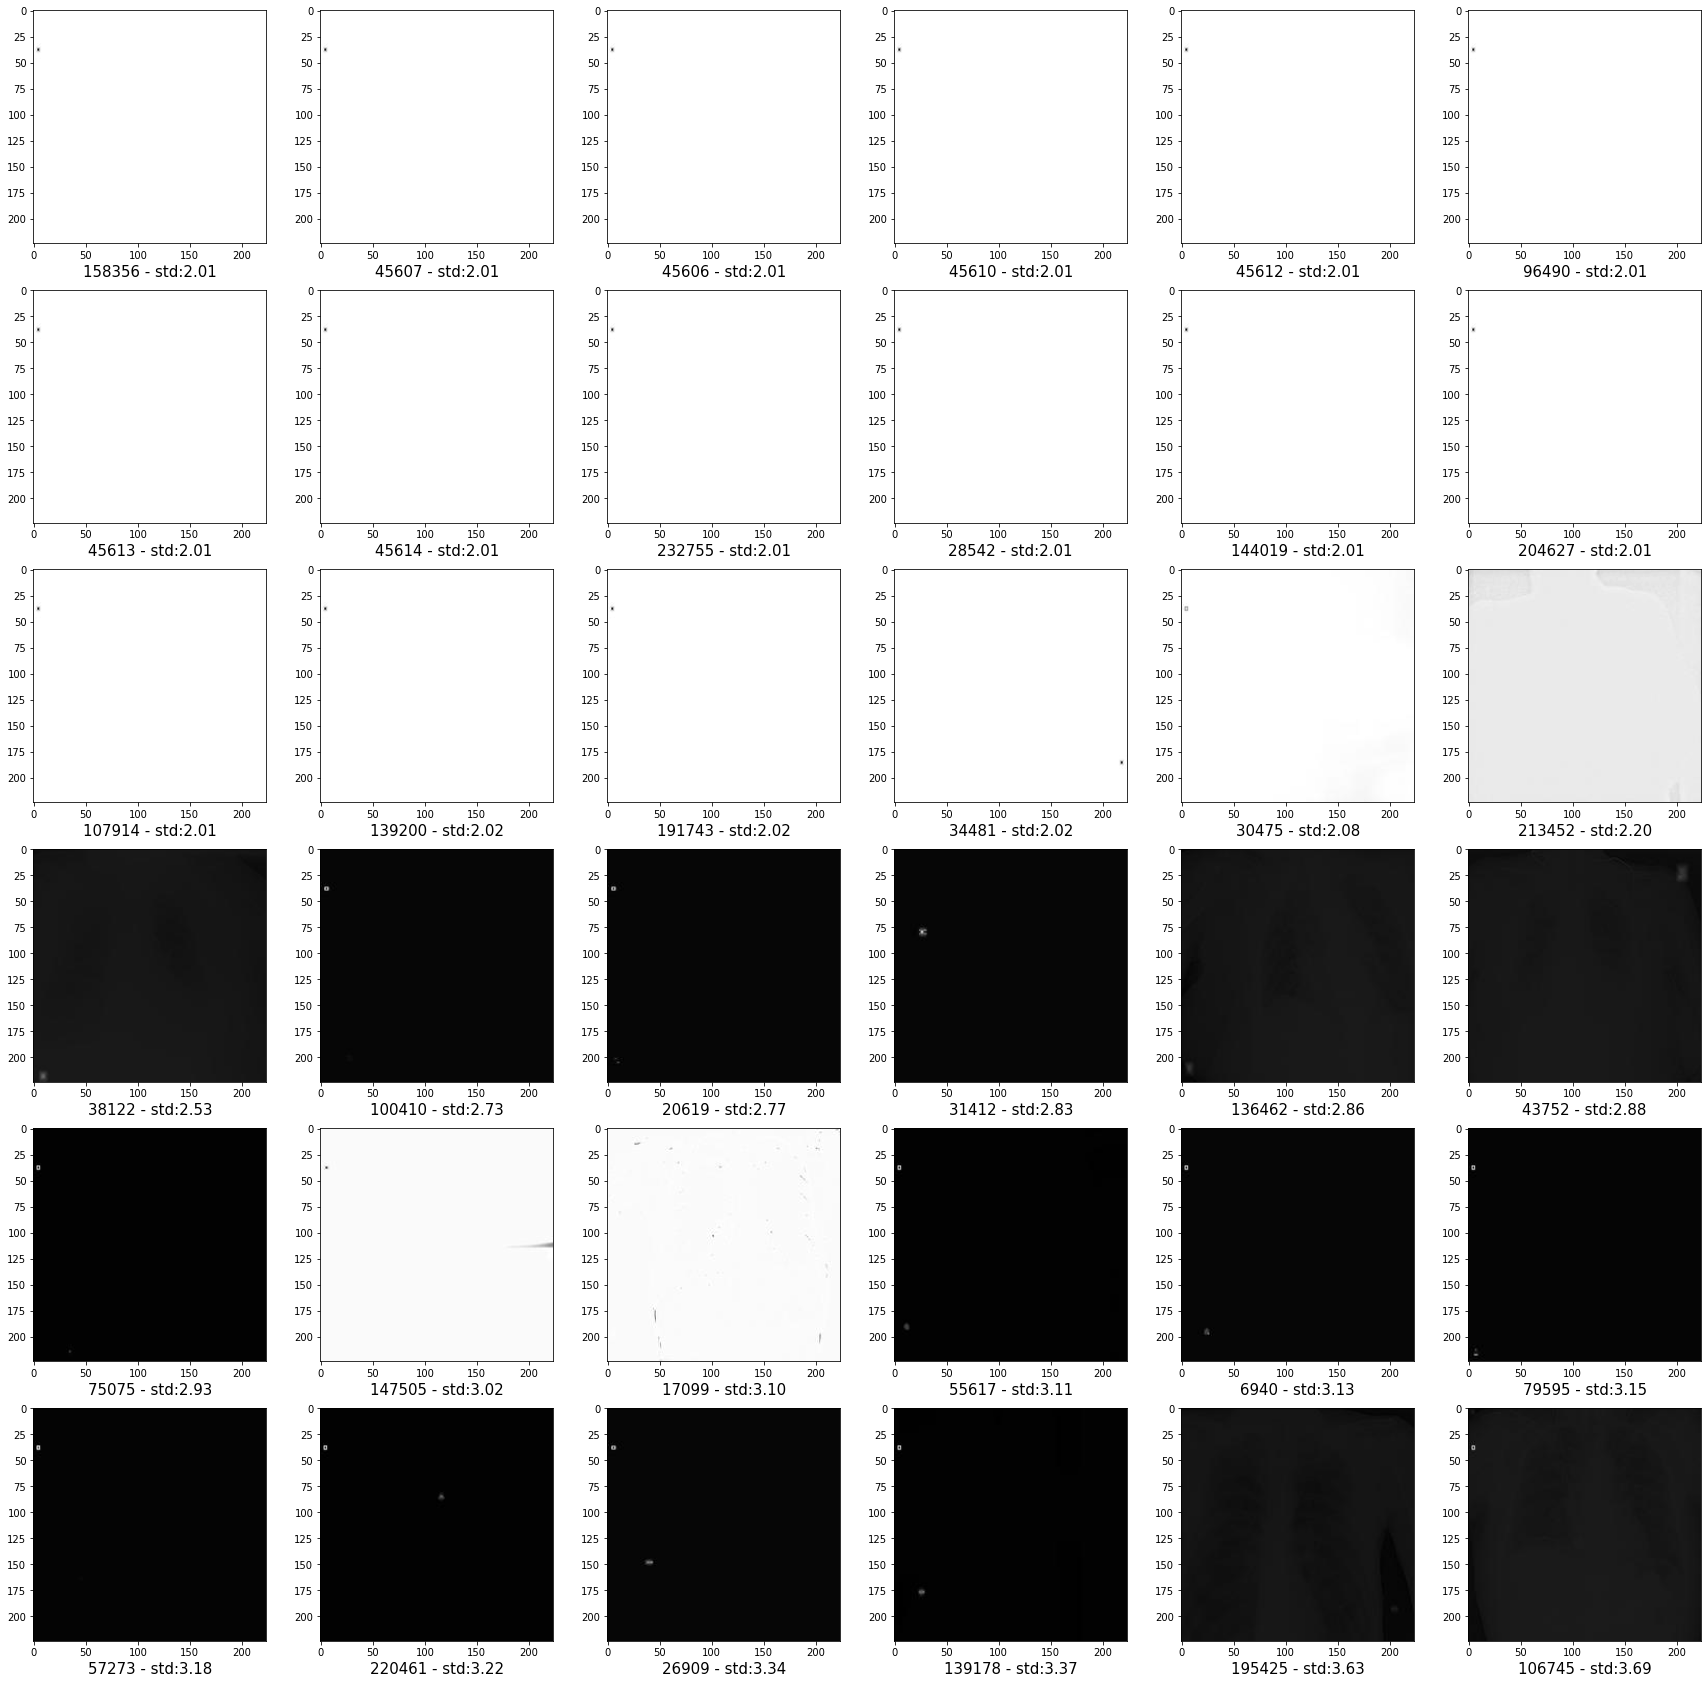

In [18]:
# Here are the images that could be discarded by std

fig, ax = plt.subplots(6,6, figsize=(30, 30))
for i,k in enumerate(np_std.argsort()[36*4:36*5]):
    im = Image.open(data.path_jpg[k])
    arr = np.array(im)
    ax[i//6][i%6].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//6][i%6].set_xlabel(f'{str(k)} - std:{np_std[k]:.2f}', fontsize=15)

In [ ]:
# Let's check at some random images we have. We're hiding the output, so no images are shown, but we'll pick one that is blurry

fig, ax = plt.subplots(6,6, figsize=(30, 30))
for i,k in enumerate(np.random.randint(data.shape[0], size=36)):
    im = Image.open(data.path_jpg[k])
    arr = np.array(im)
    ax[i//6][i%6].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//6][i%6].set_xlabel(str(k), fontsize=15)

In [11]:
# Let's pick the blurry one, and try to find similar ones
query_idx = 222529

In [12]:
query = features_pca[query_idx]
scores = features_pca @ query # Xq
print(scores.shape)

(234706,)


In [13]:
# rank by score, descending, and skip the top match (because it will be the query)
ranking_similarity = (-scores).argsort()[:]  # [:] is in case we want to filter result 1 ([1:]), which is itself, but I want it to easily compare.
ranking_different = (scores).argsort()[:] 

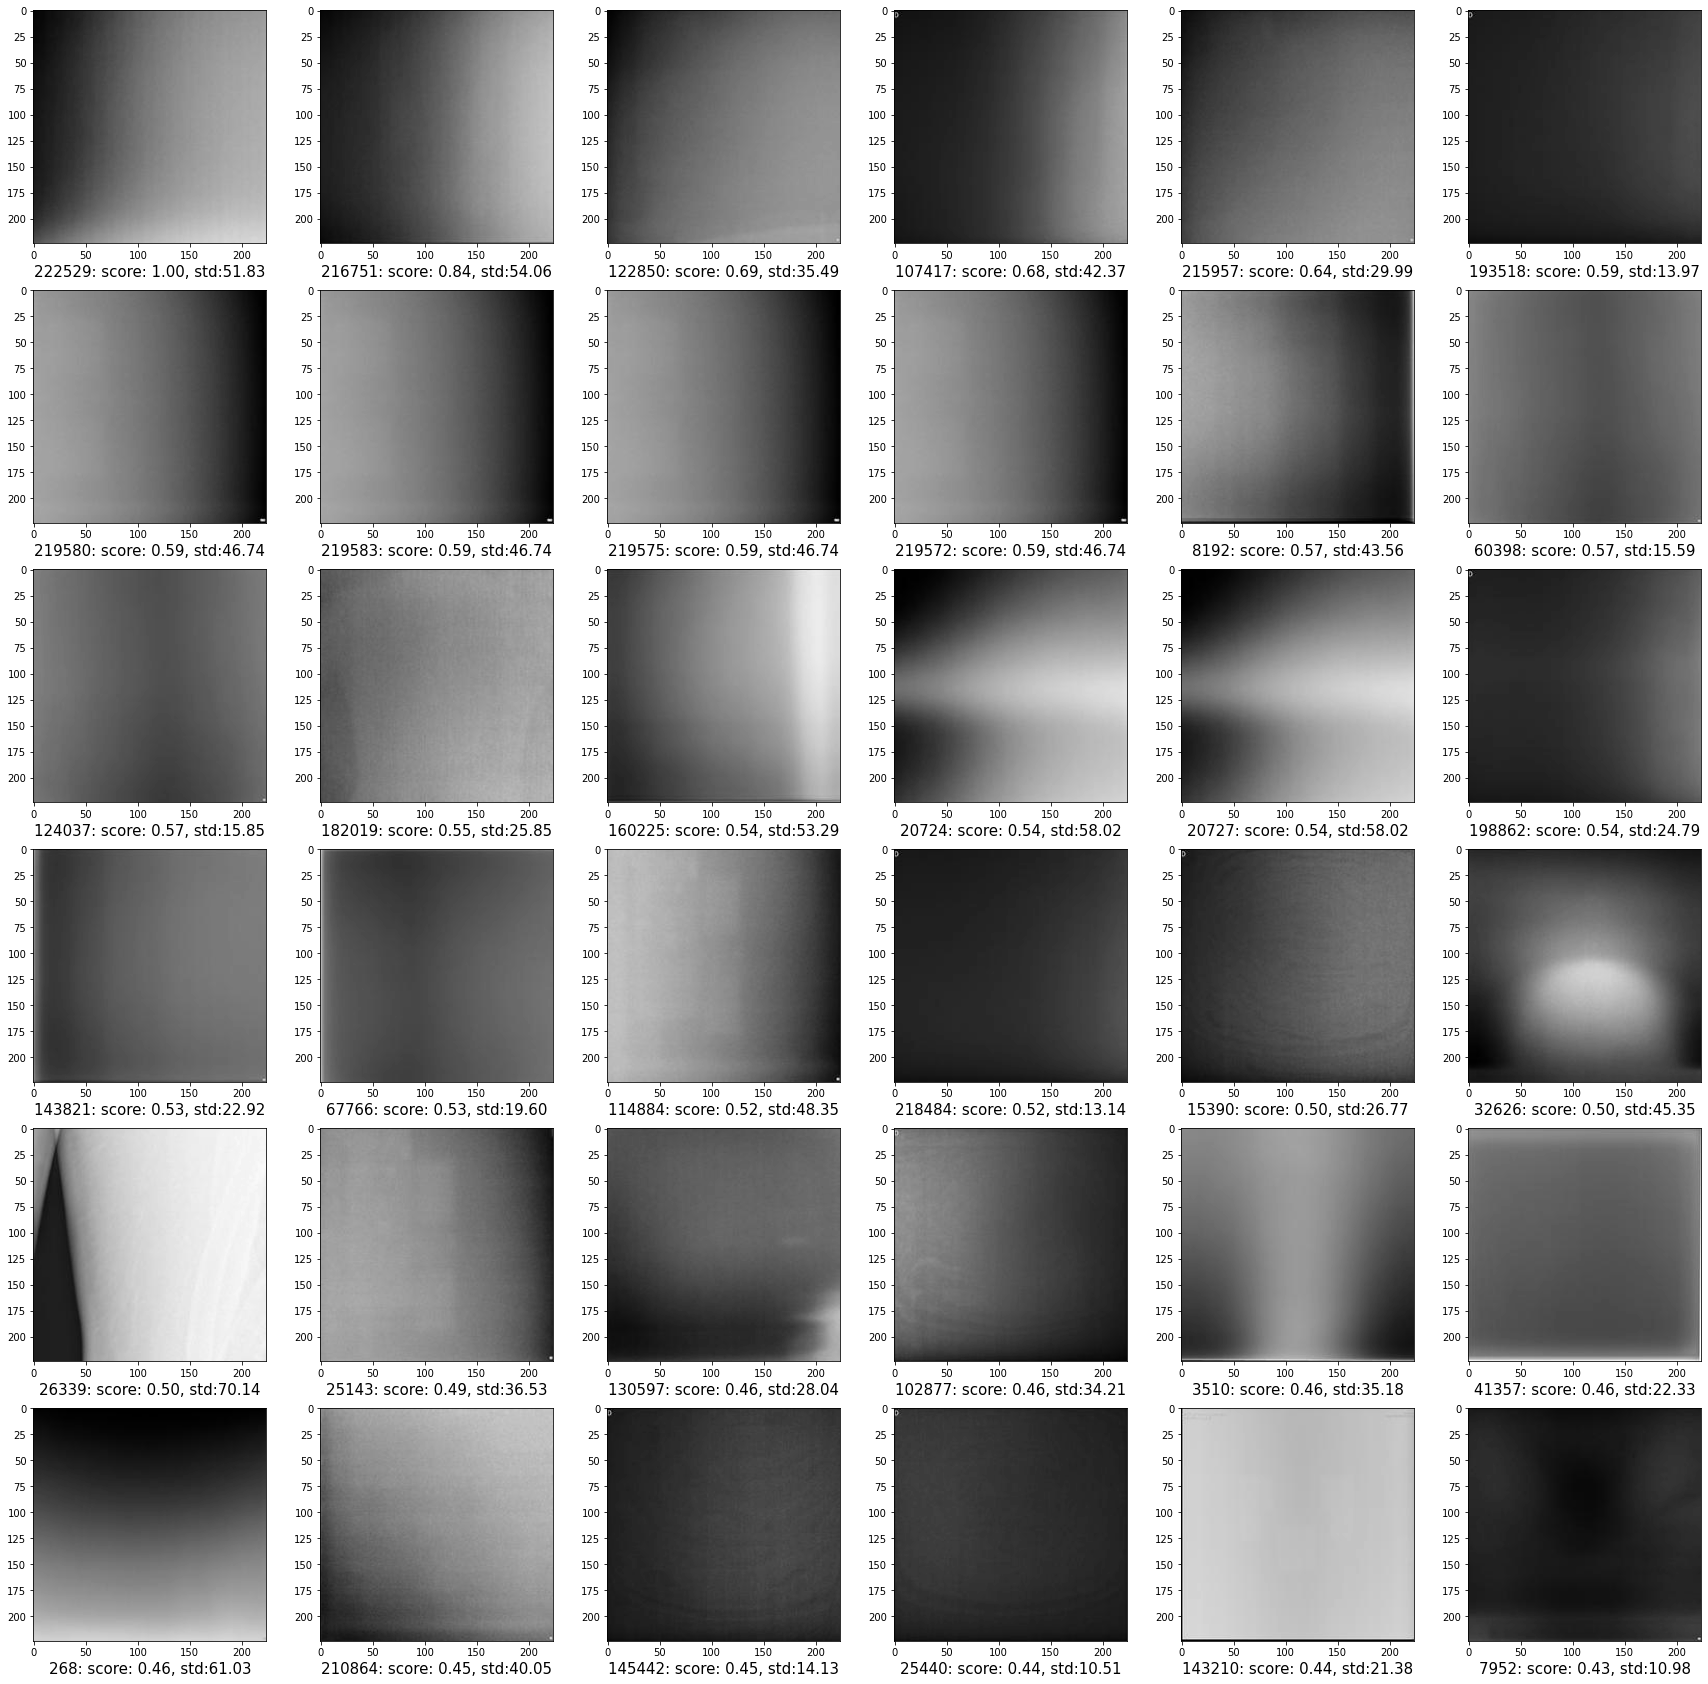

In [14]:
# Object-oriented version
# Some info: https://matplotlib.org/3.2.0/gallery/subplots_axes_and_figures/subplots_demo.html

fig, ax = plt.subplots(6,6, figsize=(30, 30))
for i,k in enumerate(ranking_similarity[:36]):
    im = Image.open(data.path_jpg[k])
    arr = np.array(im)
    ax[i//6][i%6].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//6][i%6].set_xlabel(f'{str(k)}: score: {scores[k]:.2f}, std:{np_std[k]:.2f}', fontsize=15)

# -----------------------------------

### PCA

In [30]:
PCA_values = 70
pca = PCA(PCA_values, whiten=True)
features_pca = pca.fit_transform(features_norm)
#features_pca = normalize(features_pca, norm='l2')
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative explained variation for '+str(PCA_values)+' principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.08881927 0.07178056 0.06758116 0.03405198 0.0290722  0.02641991
 0.02180858 0.01975276 0.01861713 0.01648129 0.0160059  0.01481436
 0.01423256 0.01324315 0.01265282 0.01134827 0.01120401 0.01087478
 0.01062483 0.01004016 0.00948381 0.00924946 0.00908514 0.00864982
 0.00834705 0.00819199 0.00800457 0.00785207 0.00750911 0.00730271
 0.00714673 0.00688842 0.00687641 0.00658379 0.00638495 0.00623855
 0.00604048 0.00595092 0.00580969 0.00568341 0.00563566 0.00555873
 0.00546918 0.00537005 0.00510228 0.00506332 0.00495303 0.0048519
 0.00483001 0.00475849 0.00474277 0.00455175 0.00447661 0.00437933
 0.00432651 0.00418201 0.00415346 0.00409589 0.00403827 0.00397306
 0.00394702 0.00382906 0.00376419 0.00368379 0.00361046 0.00355753
 0.00353583 0.0034552  0.00343308 0.00339949]
Cumulative explained variation for 70 principal components: 0.797432689466291


In [31]:
data['pca-one'] = features_pca[:,0]
data['pca-two'] = features_pca[:,1] 
data['pca-three'] = features_pca[:,2]

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

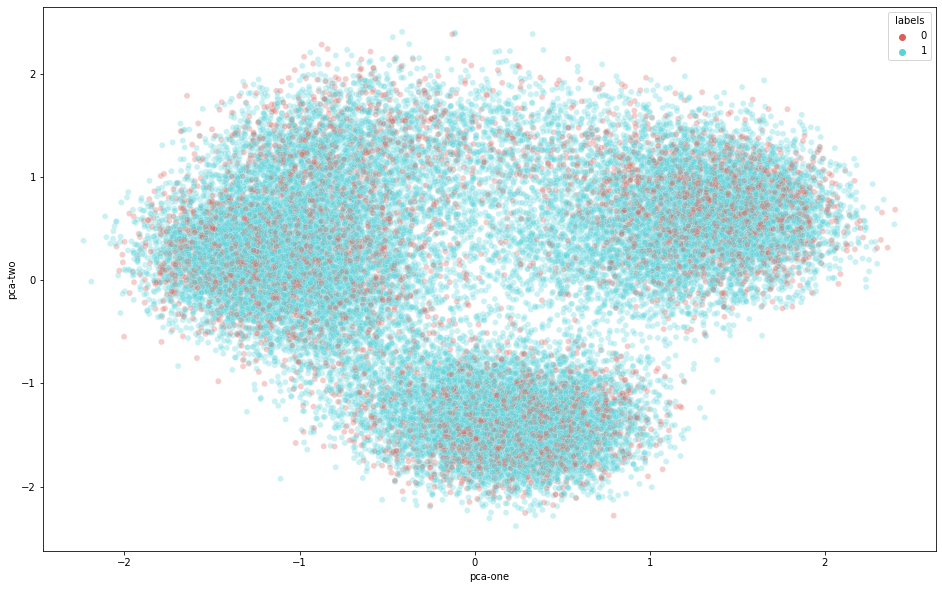

In [32]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)

# Looks like we have 3 clusters. If we try the other combinations, we see 2 clusters

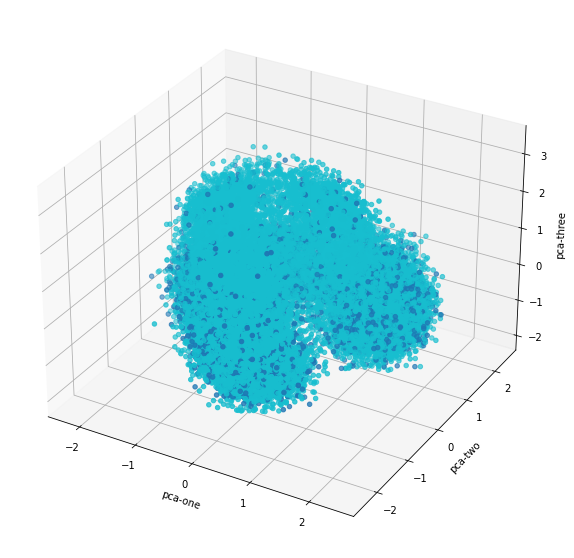

In [33]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=data["pca-one"], 
    ys=data["pca-two"], 
    zs=data["pca-three"], 
    c=data["labels"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# We see the 3 clusters we were expecting from the 2d view

### t-SNE

In [127]:
PCA_values_tSNE= [10, 20, 50, 80, 100, 150, 200, 400]


features_pca_tSNE = []

for i in PCA_values_tSNE:
    pca_tSNE = PCA(i, whiten=True)
    features_pca_tSNE_TMP = pca_tSNE.fit_transform(features_norm)
    features_pca_tSNE.append(normalize(features_pca_tSNE_TMP, norm='l2'))
    print('Cumulative explained variation for '+str(i)+' principal components: {}'.format(np.sum(pca_tSNE.explained_variance_ratio_)))

Cumulative explained variation for 10 principal components: 0.39438183970640395
Cumulative explained variation for 20 principal components: 0.5192891929391247
Cumulative explained variation for 50 principal components: 0.7179871181012467
Cumulative explained variation for 80 principal components: 0.8282704833116599
Cumulative explained variation for 100 principal components: 0.8773212320616987
Cumulative explained variation for 150 principal components: 0.9495397888928845
Cumulative explained variation for 200 principal components: 0.9794529935794624
Cumulative explained variation for 400 principal components: 0.994005790954192


In [128]:
sample_number_tsne = len(features_norm)
features_norm_subset = features_norm[:sample_number_tsne,:]   # We started with samples just to make calculations faster
labels_subset = data.labels[:sample_number_tsne].tolist()
path_subset = data.path[:sample_number_tsne].tolist()

In [129]:
selected_PCA_for_tSNE = len(PCA_values_tSNE)-1   # At nPCA = 400

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=10000)    # More info: https://distill.pub/2016/misread-tsne/
tsne_results = tsne.fit_transform(features_pca_tSNE[selected_PCA_for_tSNE][:sample_number_tsne])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 30451 samples in 1.056s...
[t-SNE] Computed neighbors for 30451 samples in 555.675s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30451
[t-SNE] Computed conditional probabilities for sample 2000 / 30451
[t-SNE] Computed conditional probabilities for sample 3000 / 30451
[t-SNE] Computed conditional probabilities for sample 4000 / 30451
[t-SNE] Computed conditional probabilities for sample 5000 / 30451
[t-SNE] Computed conditional probabilities for sample 6000 / 30451
[t-SNE] Computed conditional probabilities for sample 7000 / 30451
[t-SNE] Computed conditional probabilities for sample 8000 / 30451
[t-SNE] Computed conditional probabilities for sample 9000 / 30451
[t-SNE] Computed conditional probabilities for sample 10000 / 30451
[t-SNE] Computed conditional probabilities for sample 11000 / 30451
[t-SNE] Computed conditional probabilities for sample 12000 / 30451
[t-SNE] Computed conditional probabilities for s

In [130]:
data_subset = pd.DataFrame()
data_subset["labels"] = labels_subset
data_subset["path"] = path_subset
data_subset['tsne-2d-one'] = tsne_results[:,0]
data_subset['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

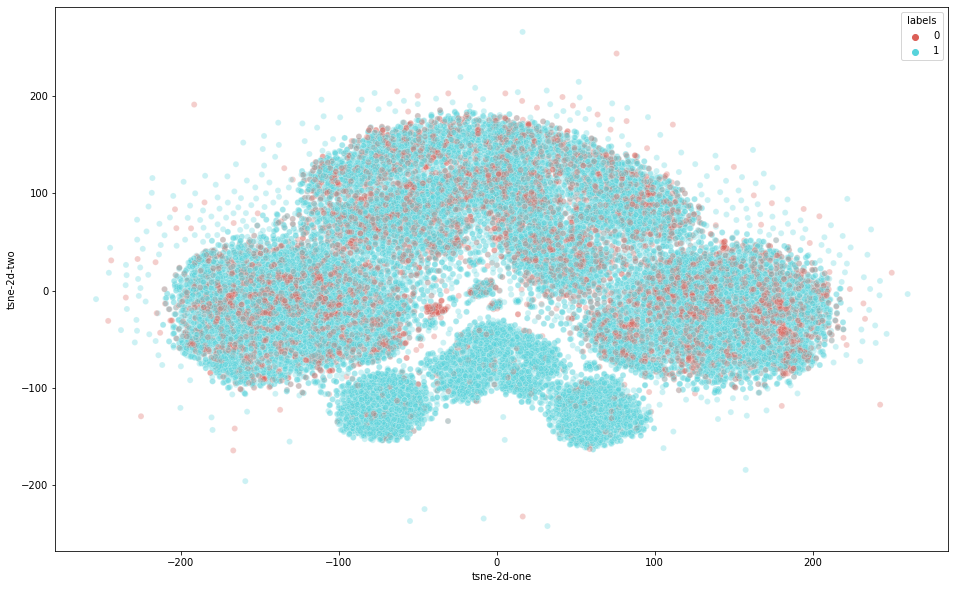

In [131]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=data_subset.labels,
    palette=sns.color_palette("hls", 2),
    data=data_subset,
    legend="full",
    alpha=0.3
)

### Find ideal number of clusters => Elbow Method

Text(0, 0.5, 'Inertia')

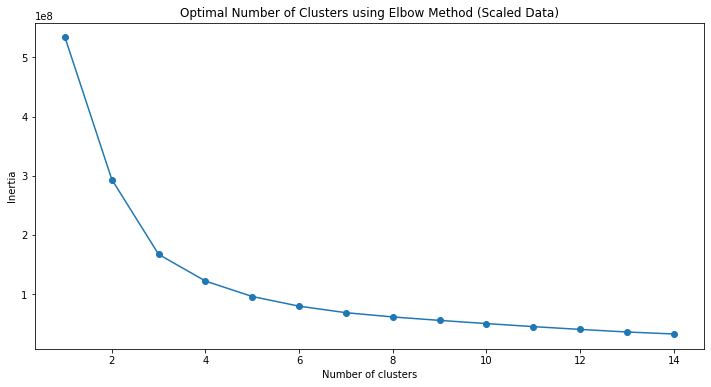

In [132]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(data_subset[["tsne-2d-one", "tsne-2d-two"]])
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [133]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [138]:
# We tried n=4, which is the one that came with the Elbow method, but the clusters we saw didn't help for our task. Now we try with a bigger number
kmeans_tsne_scale = KMeans(n_clusters=15, n_init=1000, max_iter=4000, init='k-means++', random_state=42).fit(data_subset[['tsne-2d-one', 'tsne-2d-two']])

In [139]:
print('KMeans t-SNE Scaled Silhouette Score: {}'.format(silhouette_score(data_subset[['tsne-2d-one', 'tsne-2d-two']], data_subset['labels'], metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([data_subset[['tsne-2d-one', 'tsne-2d-two']], pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans t-SNE Scaled Silhouette Score: 0.007006356492638588


/home/mboher/.conda/envs/marc-class/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


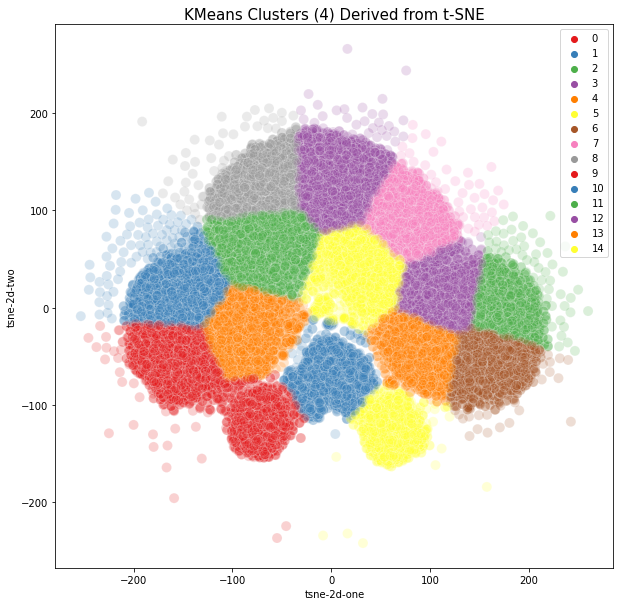

In [140]:
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1], hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from t-SNE', fontsize=15)
plt.legend()
plt.show()

In [141]:
# Let's check at the clusters size
clusters_tsne_scale.tsne_clusters.value_counts()

12    2636
2     2368
4     2294
10    2286
0     2196
5     2177
1     2158
7     2014
6     1973
8     1935
3     1776
13    1745
9     1697
11    1601
14    1595
Name: tsne_clusters, dtype: int64

In [146]:
data

,labels,path,pca-one,pca-two,pca-three,labels_pca_scale
0,0,/mnt/datasets/SIMDCAT/jpg/224/2020_03/1.3.46.6...,1.454735,0.579068,-0.557486,2
1,0,/mnt/datasets/SIMDCAT/jpg/224/2020_05/1.3.46.6...,-1.179767,0.568173,-0.918329,1
2,1,/mnt/datasets/SIMDCAT/jpg/224/2020_04/1.3.46.6...,1.543021,1.062296,-0.105536,2
3,1,/mnt/datasets/SIMDCAT/jpg/224/2020_10/1.3.46.6...,-0.593765,0.345836,0.163629,1
4,0,/mnt/datasets/SIMDCAT/jpg/224/2020_03/1.3.46.6...,-0.317632,1.826014,-0.608637,1
...,...,...,...,...,...,...
30446,1,/mnt/datasets/SIMDCAT/jpg/224/2020_07/1.3.46.6...,-1.365075,0.426364,-1.194524,1
30447,1,/mnt/datasets/SIMDCAT/jpg/224/2018_02/1.3.46.6...,-0.337291,1.234464,-0.091997,1
30448,1,/mnt/datasets/SIMDCAT/jpg/224/2018_03/1.3.46.6...,-0.912101,0.072741,0.681627,1
30449,1,/mnt/datasets/SIMDCAT/jpg/224/2018_01/1.3.46.6...,-0.171511,-0.709844,-1.099477,0


In [153]:
cluster_check = data[data.labels_pca_scale == 1].reset_index(drop=True)

In [ ]:
# We'll hide the output, so no images are shown.

fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i,k in enumerate(np.random.randint(len(cluster_check), size=9)):
    im = Image.open(cluster_check.path[k])
    arr = np.array(im)
    ax[i//3][i%3].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//3][i%3].set_xlabel(str(cluster_check.labels_pca_scale[k]), fontsize=15)